In [1]:
import glob
import logging
import os
from pathlib import Path

import cartopy.crs as ccrs
import folium
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray
from matplotlib.colors import ListedColormap
from metpy.units import units
from shapely.geometry import Polygon
from tqdm import tqdm

import G211
from lightning import get_obsgdf, ztfs

%matplotlib inline
from ml_functions import get_args, get_savedmodel_path, load_df, load_model, predct2
from spc import convective_outlook_colors, enhtstm_colors, get_issuance_time, get_outlooks
from statisticplot import ax_features, make_map, pod, stat_plots

sns.set_theme()
logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)

2024-07-18 10:06:44.913738: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 10:06:47.695206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


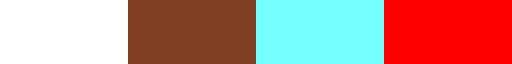

In [2]:
dpi = 200
# color map for SPC outlook
convective_outlook_colors
# color map for SPC enhanced tstm outlook
enhtstm_cmap = ListedColormap(list(enhtstm_colors.values()), name="tstm outlook")
enhtstm_cmap

In [3]:
# map projection
map_crs = G211.g211
grid = G211.grid
conus_mask = G211.mask

In [4]:
def shp2ds(gs, issue, valid_start_hour, valid_end_hour):
    """
    convert geopandas dataframe to xarray dataset
    """
    df = conus_mask.to_dataframe(name="conus").join(
        gs.drop(columns="geometry").sort_index()
    )
    da = []
    for c in df.columns:
        da.append(xarray.DataArray(df[c].unstack("x").values, name=c, dims=["y", "x"]))
    ds = xarray.merge(da)
    ds["issue"] = issue
    ds["valid_start_hour"] = valid_start_hour
    ds["valid_end_hour"] = valid_end_hour
    return ds

### Load SPC enhanced tstm outlook

In [6]:
# downloaded by get_enhtstm.ipynb
tmpdir = Path(os.getenv("TMPDIR"))
sfiles = (tmpdir / "enhtstm").glob("????/*.zip")
sfiles = sorted(sfiles)
bad_file = (
    tmpdir / "enhtstm/2020/enh12_20200215_150400_202002150222-shp.zip"
)  # incomplete
assert bad_file not in sfiles

for ifile in tqdm(sfiles):
    ofile = ifile.with_suffix(".nc")
    if os.path.exists(ofile):
        continue
    gs = geopandas.read_file(ifile)

    issue, valid_start, valid_end = get_issuance_time(ifile)

    gs = grid.to_crs(gs.crs).sjoin(gs, how="inner", rsuffix="poly")
    # convert shapes to grid
    ds = shp2ds(gs, issue, valid_start.hour, valid_end.hour)
    print(ofile)
    ds.to_netcdf(ofile)

100%|██████████| 17593/17593 [00:00<00:00, 23547.68it/s]


In [6]:
# SPC convective outlooks
convoutlook = False
if convoutlook:
    agdf = get_outlooks()
    agdf.head(170).tail()

    # examples of SPC issuances with a particular risk threshold
    risk = "ENH"
    ih = agdf["THRESHOLD"] == risk
    print(f"{sum(ih)} {risk} risk days")
    c = agdf.loc[ih].sort_values("PRODISS").PRODISS.values
    print(c[20::100])

In [7]:
m = tmpdir.glob("enhtstm/2021/enh00_20210722_222000_2021072*-shp.zip")
list(m)[1]

PosixPath('/glade/derecho/scratch/ahijevyc/tmp/enhtstm/2021/enh00_20210722_222000_202107221551-shp.zip')

In [8]:
#ifile = sfiles[5098]
#ifile = sfiles[4853]
#ifile = tmpdir / "enhtstm/2021/enh20_20210721_211600_202107210450-shp.zip"
ifile = tmpdir / "enhtstm/2021/enh00_20210819_192000_202108190503-shp.zip"
gs = geopandas.read_file(ifile)
gs = gs.rename(columns={"DN":"SPC"})
issue, valid_start, valid_end = get_issuance_time(ifile)


# Experimental: instead of setting NaNs to zero after sjoin and converting to int,
# avoid NaNs by adding a "zeros" GeoDataFrame with SPC = 0 for all area
# outside enhanced tstm polygons. Is it cleaner? Perhaps not.
# Define global geometry
global_geom = Polygon([(-180, -90), (-180, 89), (180, 89), (180, -90)])
# Set SPC = 0 in global geometry.
zeros = geopandas.GeoDataFrame(
    {"SPC": [0], "geometry": global_geom},
    crs="EPSG:4326",
)
# subtract gs area
zeros = zeros.overlay(gs.to_crs("EPSG:4326"), how="difference")
# Combine zeros area with gs.
gs = pd.concat([gs.to_crs(zeros.crs), zeros]).reset_index(drop=True)
# Assign value to grid points within polygons
gs = (
    grid[conus_mask.values.ravel()].to_crs(gs.crs).sjoin(gs, how="left", rsuffix="poly")
)
gs["issue"] = issue
# convert to str avoids TypeError: Object of type Timestamp is not JSON serializable
gs["valid_start"] = valid_start.strftime("%Y%m%d %H:%M")
gs["valid_end"] = valid_end.strftime("%Y%m%d %H:%M")
issue, valid_start, valid_end

('0600',
 datetime.datetime(2021, 8, 19, 20, 0),
 datetime.datetime(2021, 8, 20, 0, 0))

In [9]:
if convoutlook:
    import requests

    # Choose a particular convective outlook, grab issue time and expire time
    prodiss = "201803261955"
    issue = pd.to_datetime(agdf[agdf.PRODISS.eq(prodiss)].ISSUE.iloc[0])
    expire = pd.to_datetime(agdf[agdf.PRODISS.eq(prodiss)].EXPIRE.iloc[0])

    if issue < pd.to_datetime("20221128"):
        column = "THRESHOLD"
        subset = agdf["DAY"].eq(1) & agdf["CATEGORY"].eq("CATEGORICAL")
        subset = subset & agdf["PRODISS"].eq(prodiss)
        gdf = agdf[subset]
    else:
        ifile = requests.get(
            "https://www.spc.noaa.gov/products/outlook/day1otlk_cat.nolyr.geojson"
        )
        gdf = geopandas.GeoDataFrame.from_features(ifile.json())
        gdf = gdf.set_crs("epsg:4269")
        column = "LABEL"
    gdf

    if False:
        # Subtract higher thresholds from lower thresholds so they don't overlap
        cat = "TSTM"
        for subtract in ["MRGL", "SLGT", "ENH", "MDT", "HIGH"]:
            logging.debug(f"subtracting {subtract}")
            gdf.loc[gdf[column].eq(cat)] = (
                gdf.loc[gdf[column].eq(cat)]
                .overlay(gdf[gdf[column].eq(subtract)], how="difference")
                .values
            )
            cat = subtract
            if subtract not in gdf[column]:
                break

In [10]:
spc_fcst = gs.to_crs(ccrs.PlateCarree())
column = "SPC"
obsvar = "cg"
o_thresh = 1
twin = 4
rptdist = 20


args = get_args(o_thresh, twin)

setattr(args, "idate", pd.to_datetime(valid_start).floor("1D"))
args

Namespace(batchnorm=True, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=30, labels=['cg_20km_4hr', 'ic_20km_4hr', 'cg.ic_20km_4hr', 'flashes_20km_4hr', 'cg_40km_4hr', 'ic_40km_4hr', 'cg.ic_40km_4hr', 'flashes_40km_4hr'], fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=1, folds=None, kfold=1, idate=Timestamp('2021-08-19 00:00:00'), ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=10, nprocs=0, optimizer='Adam', reg_penalty=0.0, savedmodel='/glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr', seed=-1, trainstart=Timestamp('2019-10-02 00:00:00'), trainend=Timestamp('2020-12-02 00:00:00'), teststart=Timestamp('2021-01-01 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), twin=4, suite='default')

In [11]:
obsgdf = get_obsgdf(args, valid_start, valid_end, obsvar, rptdist)

2024-06-11 14:43:06,383 reading /glade/derecho/scratch/ahijevyc/tmp/HRRR.4hr.2021081900-0000.par 0.1G mtime Tue Apr  9 10:52:50 2024 240 features 8 labels and 4 index_cols & dropna.


In [12]:
import folium.plugins

m = folium.plugins.DualMap(location=[40, -95], zoom_start=3)
# 40-km rptdist
get_obsgdf(args, valid_start, valid_end, obsvar, 40).explore(
    m=m.m1, column=obsvar, name="40", cmap="pink_r",
)
# 20-km rptdist
obsgdf.explore(m=m.m2, column=obsvar, cmap="pink_r",)

2024-06-11 14:43:08,487 reading /glade/derecho/scratch/ahijevyc/tmp/HRRR.4hr.2021081900-0000.par 0.1G mtime Tue Apr  9 10:52:50 2024 240 features 8 labels and 4 index_cols & dropna.


In [13]:
m = (
    geopandas.read_file(ifile)
    .rename(columns={"DN": "SPC"})
    .explore(
        column=column,
        categories=sorted(spc_fcst[column].unique().tolist()),
        cmap=enhtstm_cmap,
        name="SPC",
    )
)
spc_fcst.explore(
    m = m,
    column=column,
    categories=sorted(spc_fcst[column].unique().tolist()),
    cmap=enhtstm_cmap,
    name="gridded SPC",
    marker_kwds=dict(radius=4),
)
obsgdf[obsgdf[obsvar] >= o_thresh].explore(
    m=m, marker_kwds=dict(color="yellow", fill=False), name=f"{obsvar} ≥ {o_thresh}"
)
folium.LayerControl().add_to(m)
m

In [14]:
# MOS LAMP lightning forecast
LAMP = False
if LAMP:
    from awips.dataaccess import DataAccessLayer

    DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
    request = DataAccessLayer.newDataRequest()
    request.setDatatype("grid")
    request.setLocationNames("LAMP2p5")
    request.setParameters("PROLGHT2hr")
    # request.setLevels("2.0FHAG")

    # Take a look at our request
    logging.info(request)

    grid_locations = DataAccessLayer.getAvailableLevels(request)
    grid_locations.sort()
    list(grid_locations)

    cycles = DataAccessLayer.getAvailableTimes(request, True)
    times = DataAccessLayer.getAvailableTimes(request)
    fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)

    # Get the most recent grid data
    response = DataAccessLayer.getGridData(request, [fcstRun[0]])

    logging.info(f"{len(times)} available times {len(fcstRun)} forecast runs")

    grid = response[0]
    data = grid.getRawData()
    lons, lats = grid.getLatLonCoords()
    bbox = [lons.min(), lons.max(), lats.min(), lats.max()]

    data[data == -999999] = np.nan
    data.min()
    np.nanmin(data)

    fig, ax = make_map(bbox=bbox, projection=map_crs)
    cs = ax.pcolormesh(lons, lats, data, cmap="pink_r", transform=ccrs.PlateCarree())
    cbar = fig.colorbar(cs, shrink=0.7, orientation="horizontal")
    cbar.set_label(
        grid.getLocationName()
        + " "
        + grid.getLevel()
        + " "
        + grid.getParameter()
        + " ("
        + grid.getUnit()
        + ") "
        + "valid "
        + str(grid.getDataTime().getRefTime())
    )

    fig2, ax2 = make_map(bbox=bbox, projection=map_crs)
    cs2 = ax2.contour(
        lons,
        lats,
        data,
        80,
        cmap="pink_r",
        levels=6,
        transform=ccrs.PlateCarree(),
        vmin=np.nanmin(data),
        vmax=np.nanmax(data),
    )
    cbar2 = fig2.colorbar(cs2, shrink=0.7, orientation="horizontal")
    cbar2.set_label(
        grid.getLocationName()
        + " "
        + grid.getLevel()
        + " "
        + grid.getParameter()
        + " ("
        + grid.getUnit()
        + ") "
        + "valid "
        + str(grid.getDataTime().getRefTime())
    )

## Define observation numpy array, geodataframe, thresholds

In [15]:
# simple 1-D numpy array of observations for verification
obs = obsgdf.set_index(["x", "y"])[obsvar]

# drop nans outside CONUS (mask applied earlier)
obs = obs[~np.isnan(obs)]

# truncate observation geodataframe based on event threshold (used for plots)
o = obsgdf[obsgdf[obsvar] >= o_thresh]

# Alternative event thresholds for observations (evenly spaced logrithmically)
thresh = np.round(np.logspace(0, 3, 16), decimals=0).astype(int)
thresh = pd.Series([o_thresh], name=f"{obsvar} threshold")

### Verify SPC enhanced tstm forecast

In [16]:
fcst = spc_fcst
# so we can apply 6045-element mask
fcst = fcst.merge(grid, on=["x", "y"], how="right")
fcst = fcst.SPC / 100
# Drop values outside CONUS
fcst = fcst[conus_mask.data.ravel()]
# Assign 0 to points outside forecast polygons
fcst[np.isnan(fcst)] = 0
fcst.name = "SPC"

pthresh = pd.Series([10, 40, 70], name=f"fcst prob\nthresh") / 100.0

In [17]:
fcst

x   y 
48  12    0.0
49  12    0.0
69  12    0.1
70  12    0.1
47  13    0.0
         ... 
25  46    0.0
26  46    0.0
27  46    0.0
28  46    0.0
29  46    0.0
Name: SPC, Length: 1308, dtype: float64

/glade/derecho/scratch/ahijevyc/tmp/spc.png


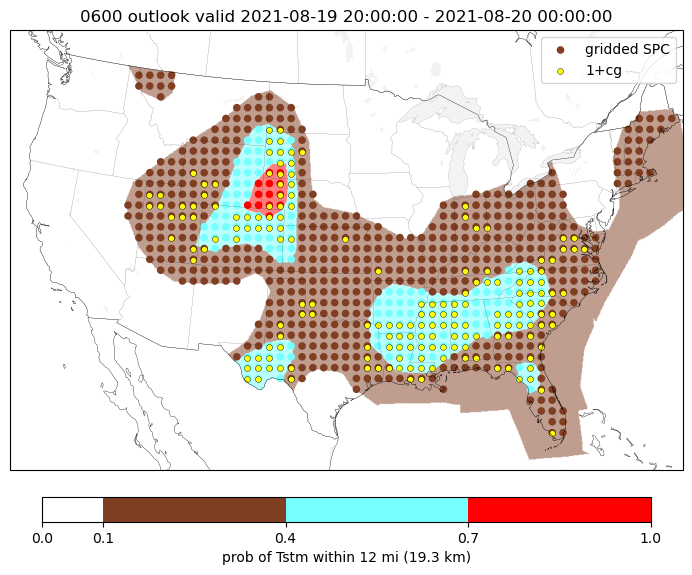

In [18]:
sns.reset_defaults()
fig, ax = make_map()
ax.set_title(f"{issue} outlook valid {valid_start} - {valid_end}")
gs = geopandas.read_file(ifile).to_crs(ax.projection)
gs["DN"] /= 100.
gs.plot(
    ax=ax,
    column="DN",
    cmap=enhtstm_cmap,
    alpha=0.5,
    legend=True,
    norm=mpl.colors.BoundaryNorm(boundaries=[0, .10, .40, .70, 1], ncolors=4),
    legend_kwds=dict(shrink=0.7, orientation="horizontal", aspect=25, pad=0.05,
                    label=f"prob of Tstm within 12 mi ({(12*units.miles).to('km'):~.1f})",
                    spacing="proportional",
                    ),
)

gs = spc_fcst.copy()
gs["SPC"] /= 100.
gs.where(gs.SPC>0).plot(
    column="SPC",
    ax=ax,
    cmap=enhtstm_cmap,
    norm=mpl.colors.BoundaryNorm(boundaries=[0, .10, .40, .70, 1], ncolors=4),
    marker="o",
    markersize=20,
    transform=ccrs.PlateCarree(),
    label="gridded SPC",
)

o_kw = {"marker":"o",
        "markersize":18,
        "edgecolor":"black",
        "facecolor":"yellow",
        "label":f"{o_thresh}+{obsvar}",
        "linewidths":0.3,
       }
o.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    **o_kw,
)

leg = ax.legend()
plt.tight_layout()
ofile = tmpdir / "spc.png"
fig.savefig(ofile, dpi=dpi)
print(ofile)
fig

0.259


2024-06-11 14:43:15,788 /glade/derecho/scratch/ahijevyc/tmp/t.png


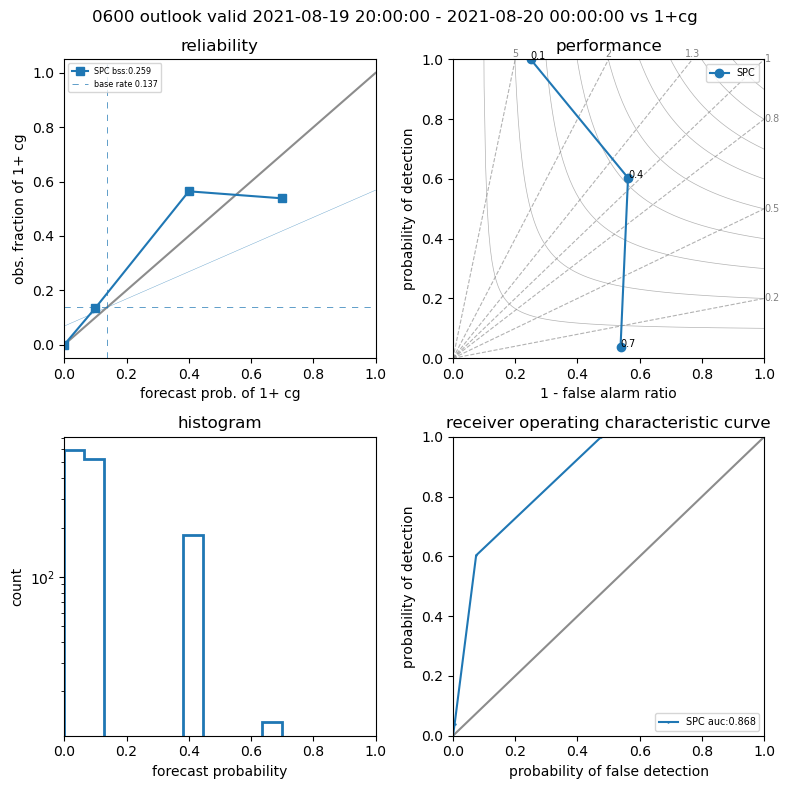

In [19]:
fig0 = stat_plots(
    obs,
    fcst,
    thresh=thresh,
    pthresh=pthresh,
    o_thresh_roc=o_thresh,
    sep=0.01,
    n_bins=11,
    suptitle=f"{issue} outlook valid {valid_start} - {valid_end} vs {o_thresh}+{obsvar}",
)
ofile = tmpdir / "t.png"
fig0.savefig(ofile, dpi=dpi)
logging.warning(ofile)
fig0

## Verify dense neural network forecast

In [20]:
df = load_df(args)

# Put "valid_time", "y", and "x" in MultiIndex so we can group by them later.
# Used here and when calculating ensemble mean.
levels = ["initialization_time", "valid_time", "y", "x"]
df = df.set_index(levels)
feature_levels = ["forecast_hour", "lat", "lon"]
df = df.set_index(feature_levels, drop=False, append=True)
levels = levels + feature_levels

# make sure df label is same as obs (got earlier)
assert all(
    df[f"{obsvar}_{rptdist}km_{twin}hr"].xs(
        valid_start + pd.Timedelta(hours=twin / 2), level="valid_time"
    )
    == obs.values
)

2024-06-11 14:43:16,170 reading /glade/derecho/scratch/ahijevyc/tmp/HRRR.4hr.2021081900-0000.par 0.1G mtime Tue Apr  9 10:52:50 2024 240 features 8 labels and 4 index_cols & dropna.


In [21]:
savedmodel = get_savedmodel_path(args, odir="/glade/work/ahijevyc/NSC_objects/nn")
logging.warning(savedmodel)
ifold, thisfit = 0,0
savedmodel_thisfitfold = f"{savedmodel}_{thisfit}/{args.kfold}fold{ifold}"
model = load_model(savedmodel_thisfitfold)
model.summary()

2024-06-11 14:43:16,499 /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr


Model: "fit_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              246784    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 254984 (996.03 KB)
Trainable params: 254984 (996.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
index = pd.MultiIndex.from_product(
    [range(args.kfold), range(args.nfits)], names=["fold", "fit"]
)

Y = pd.concat([predct2(i, args, df) for i in index], keys=index, names=index.names)

2024-06-11 14:43:19,491 (0, 0) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_0/1fold0


7/7 [==============================] - 1s 44ms/step


2024-06-11 14:43:21,029 (0, 1) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_1/1fold0


7/7 [==============================] - 0s 44ms/step


2024-06-11 14:43:22,243 (0, 2) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_2/1fold0


7/7 [==============================] - 0s 51ms/step


2024-06-11 14:43:23,430 (0, 3) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_3/1fold0


7/7 [==============================] - 0s 42ms/step


2024-06-11 14:43:24,606 (0, 4) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_4/1fold0


7/7 [==============================] - 1s 71ms/step


2024-06-11 14:43:25,859 (0, 5) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_5/1fold0


7/7 [==============================] - 0s 45ms/step


2024-06-11 14:43:27,244 (0, 6) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_6/1fold0


7/7 [==============================] - 0s 48ms/step


2024-06-11 14:43:28,782 (0, 7) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_7/1fold0


7/7 [==============================] - 0s 42ms/step


2024-06-11 14:43:29,953 (0, 8) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_8/1fold0


7/7 [==============================] - 0s 45ms/step


2024-06-11 14:43:31,205 (0, 9) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_9/1fold0


7/7 [==============================] - 0s 47ms/step


In [23]:
# I may have overlapping valid_times from different init_times like fhr=1 from today and fhr=25 from previous day
# average probability over all nfits initialized at initialization_time and valid at valid_time
ensmean = Y.groupby(level=levels).mean()
assert (
    "fit" not in ensmean.index.names
), "fit should not be a MultiIndex level of ensmean, the average probability over nfits."

dnntimes = pd.date_range(
    start=valid_start + pd.Timedelta(hours=twin / 2),
    end=valid_end - pd.Timedelta(hours=twin / 2),
    freq=f"{twin}h",
)

idx = pd.IndexSlice
ensmean = ensmean.loc[idx[:, dnntimes], :].xs("y_pred", axis="columns", level=0)
ensmean.groupby("valid_time").first().index

DatetimeIndex(['2021-08-19 22:00:00'], dtype='datetime64[ns]', name='valid_time', freq=None)

2024-06-11 14:47:56,990 /glade/derecho/scratch/ahijevyc/tmp/ztfs.png


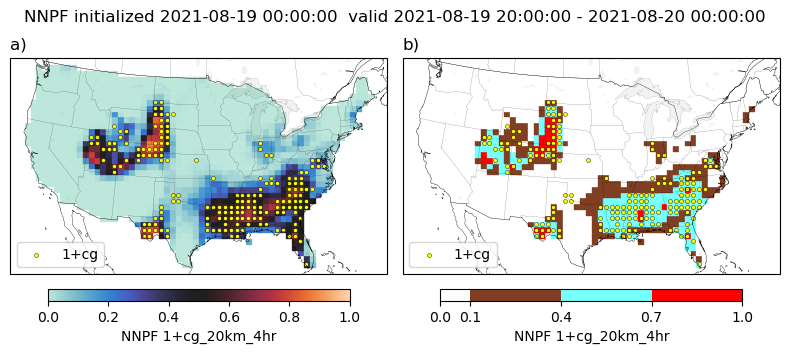

In [26]:
import matplotlib

o_kw.update({"markersize":8})
matplotlib.pyplot.close()
sns.reset_defaults()
f = f"{obsvar}_{rptdist}km_{twin}hr"
labels = (
    Y.groupby(level=levels)
    .mean()
    .loc[idx[:, dnntimes], :]
    .xs("y_label", axis="columns", level=0)
)

assert np.all(labels[f].values == obs)


def getp(ensmean):
    # probability of no occurences during long time window = product of 1-p for all
    # smaller time window pieces

    prob_none = (1 - ensmean).groupby(["y", "x"]).prod()
    # 1 minus prob_none = prob of at least one occurence.
    p = 1 - prob_none
    # add to df so we can use df's lat and lon for coordinates.
    p["lon"] = df.groupby(["y", "x"]).mean(numeric_only=True).lon
    p["lat"] = df.groupby(["y", "x"]).mean(numeric_only=True).lat
    return p


def put_colorbar(fig, ax):
    cb = fig.colorbar(
        ax.findobj(match=matplotlib.collections.PathCollection)[0],
        ax=ax,
        shrink=0.8,
        orientation="horizontal",
        aspect=25,
        pad=0.05,
        spacing="proportional",
        label=f"NNPF {o_thresh}+{f}",
    )
    return cb


p_kw = dict(
    kind="scatter",
    x="lon",
    y="lat",
    s=12.1,
    marker="s",
    transform=ccrs.PlateCarree(),
    colorbar=False,
    #label="NNPF",
)

fig, axes = plt.subplots(ncols=2, figsize=(8, 3.55), subplot_kw={"projection": map_crs}, sharey=True)
ax = axes[0]
p = getp(ensmean)

ax = p.plot(
    ax=ax,
    cmap="icefire",
    c=f,
    vmax=1,
    **p_kw,
)
cb = put_colorbar(fig, ax)

ax = axes[1]
# 0-10-40-70
p = getp(ensmean.map(ztfs, how="floor"))
ax = p.plot(
    ax=ax,
    cmap=enhtstm_cmap,
    c=f,
    norm=mpl.colors.BoundaryNorm(boundaries=[0.00, 0.10, 0.40, 0.70, 1.00], ncolors=4),
    **p_kw,
)
cb = put_colorbar(fig, ax)
fig.suptitle(f"NNPF initialized {args.idate}  valid {valid_start} - {valid_end}")

for ax in axes:
    ax = ax_features(ax)
    ax = o.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        **o_kw,
    )
    leg = ax.legend()

axes[0].set_title('a)', loc="left")
axes[1].set_title('b)', loc="left")

ofile = tmpdir / "ztfs.png"
plt.tight_layout()
fig.savefig(ofile, dpi=dpi)
logging.warning(ofile)
fig

In [25]:
p[f].value_counts()

cg_20km_4hr
0.0    907
0.1    192
0.4    173
0.7     36
Name: count, dtype: int64

0.345


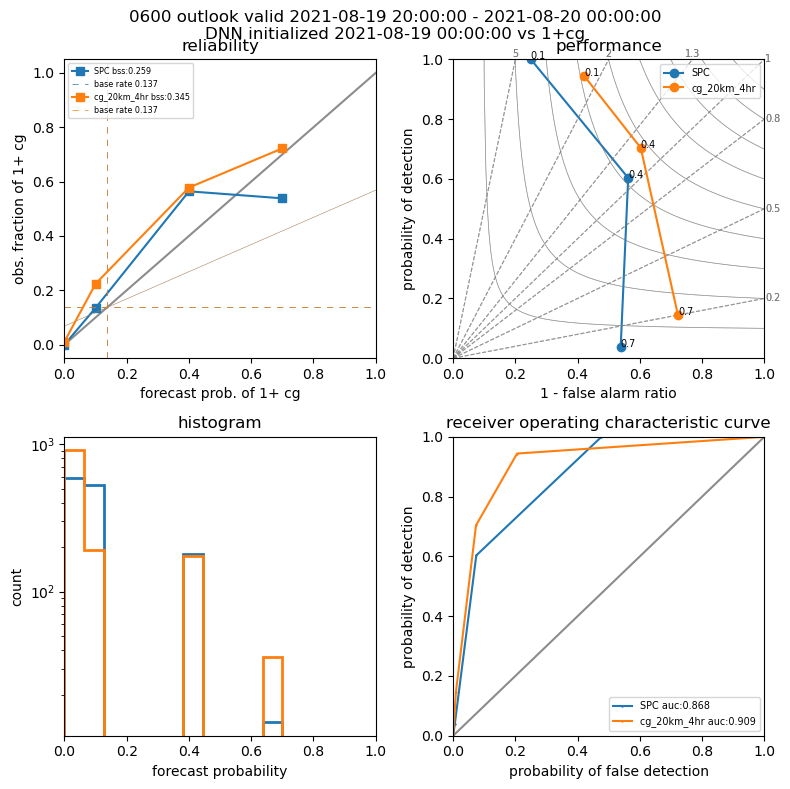

In [26]:
fcst = p[f]
#pthresh = pd.Series(np.round(np.arange(0.2, 1, 0.2), 2), name=f"fcst\np thresh")

fig0 = stat_plots(
    obs,
    fcst,
    thresh=thresh,
    pthresh=pthresh,
    o_thresh_roc=o_thresh,
    sep=0.15,
    n_bins=11,
    suptitle=(
        f"{issue} outlook valid {valid_start} - {valid_end}"
        f"\nDNN initialized {args.idate} vs {o_thresh}+{obsvar}"
    ),
    fig=fig0,
)

fig0.savefig(tmpdir / "t.png", dpi=dpi)
fig0

In [27]:
0.1 >= (pd.Series([10, 40, 70], name=f"fcst prob\nthresh") / 100.0)

0     True
1    False
2    False
Name: fcst prob\nthresh, dtype: bool

In [28]:
fcst.iloc[3]

0.10000000000099996

In [29]:
fcst >= 0.1

y   x 
12  48    False
    49    False
    69     True
    70     True
13  47    False
          ...  
46  25    False
    26    False
    27    False
    28    False
    29    False
Name: cg_20km_4hr, Length: 1308, dtype: bool

In [30]:
[pod(obs >= thresh[0], fcst >= p) for p in pthresh]

[0.9441340782122905, 0.7039106145251397, 0.1452513966480447]

In [31]:
pthresh

0    0.1
1    0.4
2    0.7
Name: fcst prob\nthresh, dtype: float64

In [32]:
np.finfo(float).eps

2.220446049250313e-16